In [1]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

#### Lazy老师说， synthetic data很有用, 用一个假数据试试

**实际的30日LTV分布，按照不同金额段来看，都是一个指数分布的样子， 合到一起，是一个极其偏的分布**

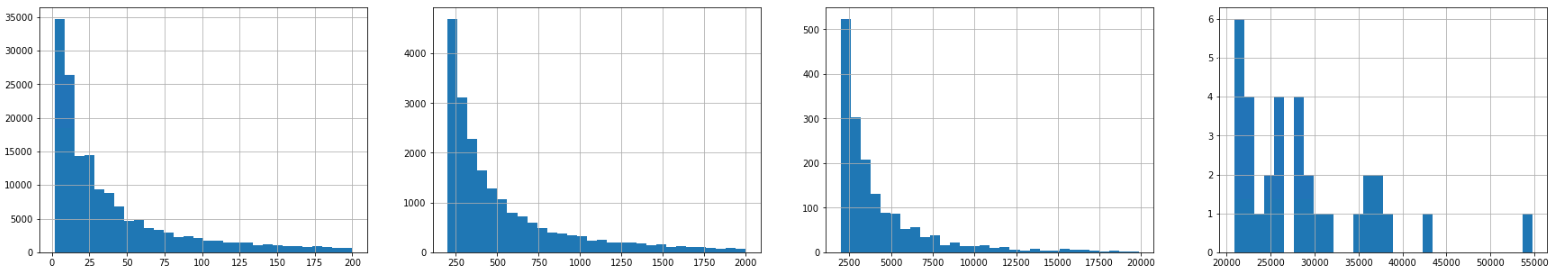

#### 假数据： 用两个不同大小的指数分布，合到一起，造成一个贼偏的数据

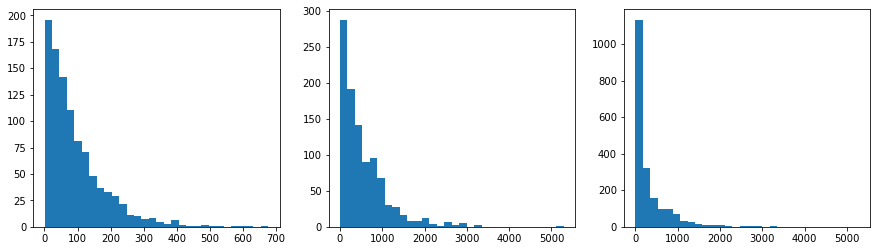

In [2]:
a1 = np.random.exponential(100, size = 1000)
a2 = np.random.exponential(500, size = 1000)
                                                                             

figsize(15,4)
plt.subplot(1,3,1)
plt.hist(a1, bins = 30)

plt.subplot(1,3,2)
plt.hist(a2, bins = 30)

plt.subplot(1,3,3)
plt.hist(np.r_[a1, a2], bins = 30)
plt.show()

## 做一些假设，假设，总共有两个类别，对每个类别，有那么一个先验

In [3]:
data = np.r_[a1, a2]

clusters = 2
n_total = len(data)

priors = [200, 600]

## 用pymc搞一搞

In [4]:
with pm.Model() as arpu_model:
    
    # 迪利克雷分布生成一个离散的multinomial
    p = pm.Dirichlet('p', a=np.ones(clusters))
    
    # 对数据集里面的每一个数据点，按照概率打label
    category = pm.Categorical('category', p=p, shape=n_total)
    
    # 估计likehood的参数 lambda， 假设又两个组，先验是priors
    lambdas = pm.Normal('lambdas', mu = priors, sd = 300, shape = clusters)
    
    # likelihood的构造
    y = pm.Exponential('y', lam=1 / lambdas[category], observed=data)
    
    # 分类变量
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    
    # 连续变量，避免出错， metropolis
    step2 = pm.Metropolis(vars=[p, lambdas])
    trace = pm.sample(10000, step=[step1, step2], return_inferencedata = True)

<ipython-input-4-76d98e817efd>:16: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [lambdas]
>>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 336 seconds.
C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


In [5]:
figsize(15,6)

## 两个指数分布lambda的估计

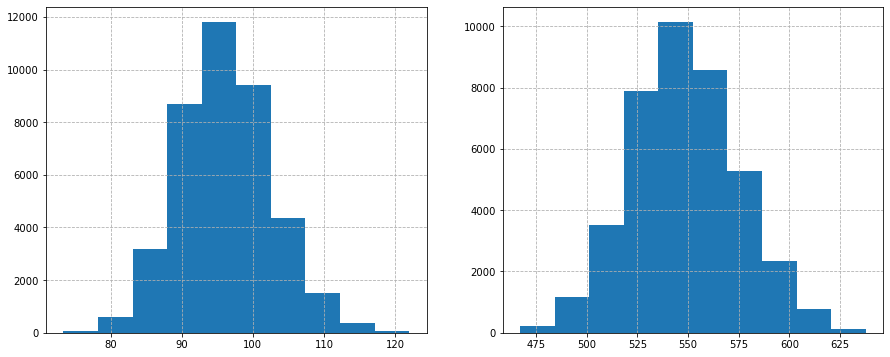

In [6]:
plt.subplot(1,2,1)
plt.hist(trace.posterior['lambdas'].values[:,:,0].reshape(-1))
plt.grid(linestyle = '--')
plt.subplot(1,2,2)
plt.hist(trace.posterior['lambdas'].values[:,:,1].reshape(-1))
plt.grid(linestyle = '--')
plt.show()

In [7]:
import arviz as az

## 对任意一个点，被分配到两个cluster的概率

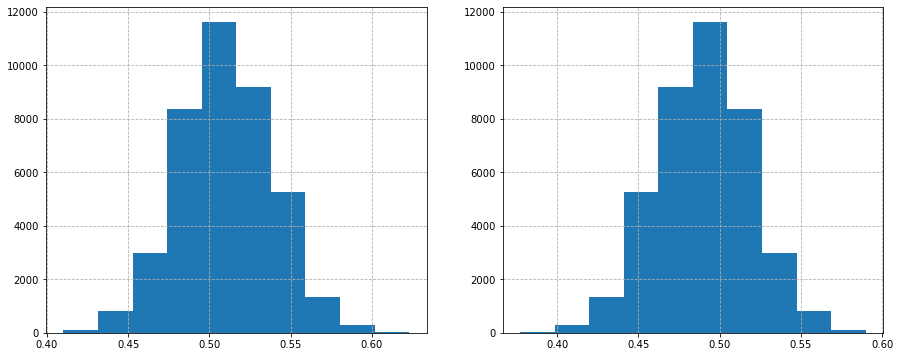

In [8]:
plt.subplot(1,2,1)
plt.hist(trace.posterior['p'].values[:,:,0].reshape(-1))
plt.grid(linestyle = '--')
plt.subplot(1,2,2)
plt.hist(trace.posterior['p'].values[:,:,1].reshape(-1))
plt.grid(linestyle = '--')

## 这样我们就用两个分布代替了一个分布

### Mixture models


有时候我们就是有那么一个bimodal的distribution.       
说衡量成年人身高的时候，我们可以用一个男人的身高分布和一个女人的身高分布组合而成。      
当这个数据集中含有小孩的时候，我们甚至还要加上一个小孩的身高分布。      
当我们做MNIST这个数据集的时候，我们甚至需要10个分布才行。       


**Gaussian 是一个对称的分布，单一modal的分布， 但是如果有多个高峰，不对称，倾斜的分布，怎么搞?**

**对于任意的分布，我们都可以用好多好多好多个高斯分布来近似的。这个很厉害**

We have a certainnumber of subpopulations, each one represented by some distribution, and we       
have data points that belong to those distribution but we do not know to which    
distribution each point belongs.     

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
sns.set()

#### Make a mixing distribution

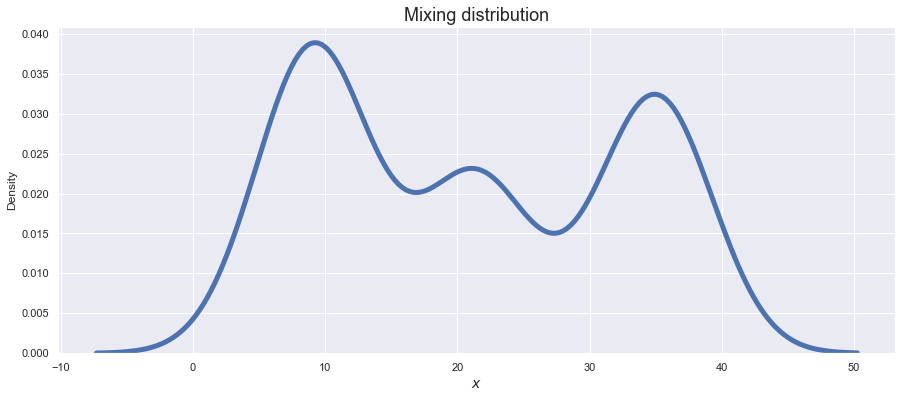

In [24]:
clusters = 3
n_cluster = [90,50,75]
n_total = sum(n_cluster)
means = [9,21,35]
std_devs = [2,2,2]
mix = np.random.normal(np.repeat(means,n_cluster), np.repeat(std_devs,n_cluster))
sns.kdeplot(mix, lw = 5)
plt.xlabel('$x$', fontsize = 14)
plt.title('Mixing distribution', fontsize = 18)
plt.show()

Suppose we know: 
1. The data can be modelled with 2 gaussians
2. We know the means and devs of the gaussian distributions.

Problem:          
Assign each point to one of the 2 gaussians.

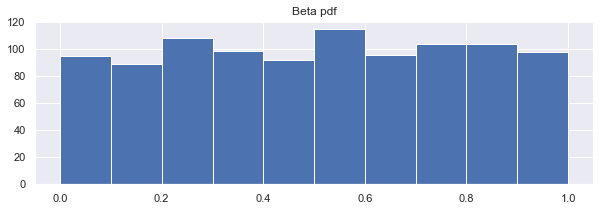

In [35]:
with pm.Model() as model:
    b = pm.Beta('beta',1,1)
    
figsize(10,3)
plt.hist(b.random(size = 1000))
plt.title('Beta pdf')
plt.show()

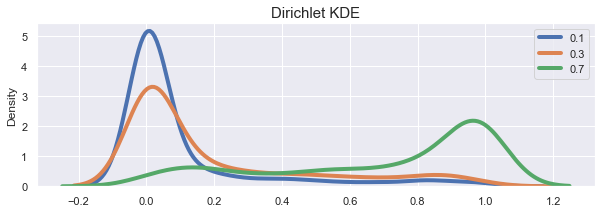

In [54]:
with pm.Model() as model:
    b = pm.Dirichlet('beta',[0.1,0.2,0.7])
    
d = b.random(size = 1000)
sns.kdeplot(d[:,0], label = '0.1', lw = 4)
sns.kdeplot(d[:,1], label = '0.3', lw = 4)
sns.kdeplot(d[:,2], label = '0.7', lw = 4)
plt.legend(loc = 'upper right')
plt.title('Dirichlet KDE', fontsize = 15)
plt.show()

**You can use these 2 distributions to model probabilities.**

In [58]:
with pm.Model() as model:
    # three probabilities
    p = pm.Dirichlet('p',a = np.ones(clusters))
    
    # assigned to different data point
    category = pm.Categorical('category', p = p,shape = n_total)
    
    # category is an index, use it to retrieve distributions
    # use distributions to produce data
    means = pm.math.constant([10,20,35])
    
    y = pm.Normal('y', means[category], sd = 2, observed = mix)
    step1 = pm.ElemwiseCategorical(vars =[category], values = range(clusters))
    step2 = pm.Metropolis(vars = [p])
    trace = pm.sample(10000, step = [step1, step2], return_inferencedata = True)

<ipython-input-58-54dfde6d2354>:6: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step1 = pm.ElemwiseCategorical(vars =[category], values = range(clusters))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 53 seconds.
C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


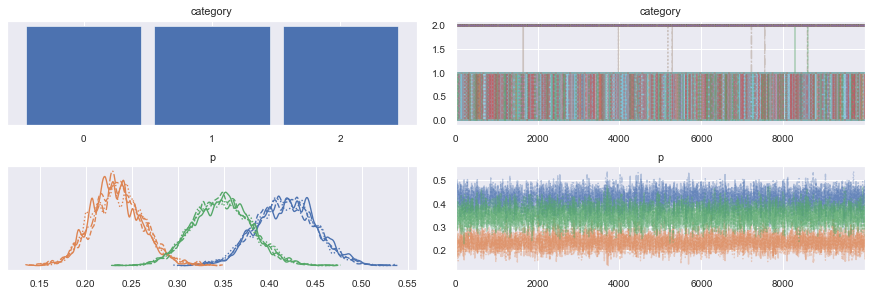

In [60]:
import arviz as az
az.plot_trace(trace)
plt.show()

**This solves the problem: how to assign datapoints to distributions.**

#### What if you dont know the distributions(parameters of the distributions. fuck..)

In [84]:
with pm.Model() as model:
    # three probabilities
    p = pm.Dirichlet('p',a = np.ones(clusters))
    
    # assigned to different data point
    category = pm.Categorical('category', p = p,shape = n_total)
    
    # category is an index, use it to retrieve distributions
    
    # set some priors on the distributions
    means = pm.Normal('means',[3,15,43], sigma =10, shape = clusters)
    sigmas = pm.HalfNormal('sigmas',5, shape = clusters)
    
    y = pm.Normal('y', means[category], sigma = sigmas[category], observed = mix)
    step1 = pm.ElemwiseCategorical(vars =[category], values = range(clusters))
    step2 = pm.Metropolis(vars = [p])
    trace = pm.sample(30000, step = [step1, step2], return_inferencedata = True)

<ipython-input-84-1233670581d4>:14: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step1 = pm.ElemwiseCategorical(vars =[category], values = range(clusters))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>Metropolis: [p]
>NUTS: [sigmas, means]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 153 seconds.
C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


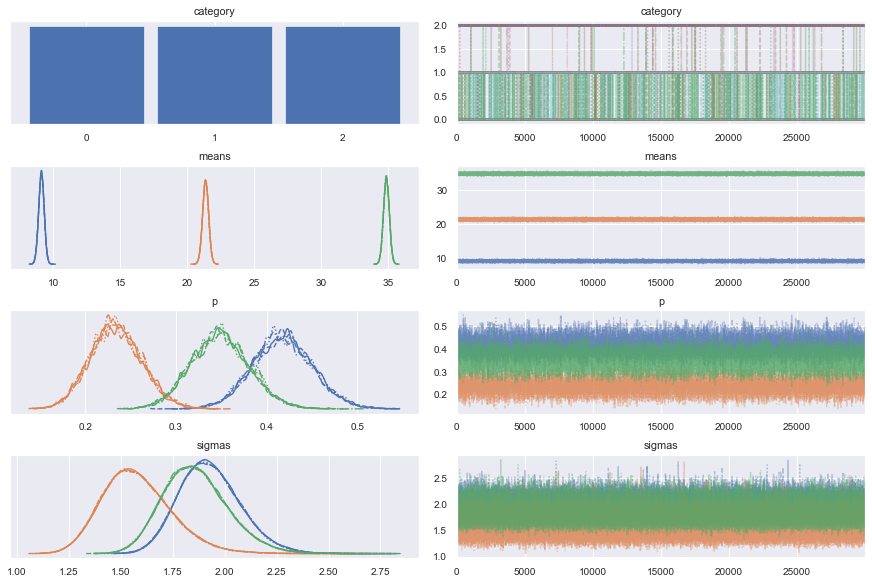

In [85]:
az.plot_trace(trace)
plt.show()

In [90]:
az.summary(trace, var_names = ['p','means','sigmas'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.418,0.033,0.354,0.479,0.000,0.0,12669.0,15394.0,1.0
p[1],0.234,0.029,0.180,0.287,0.000,0.0,10470.0,13945.0,1.0
p[2],0.349,0.032,0.287,0.408,0.000,0.0,15529.0,19191.0,1.0
means[0],9.108,0.205,8.721,9.494,0.000,0.0,169128.0,98475.0,1.0
means[1],21.381,0.225,20.952,21.800,0.001,0.0,176544.0,97492.0,1.0
means[2],34.894,0.216,34.489,35.303,0.001,0.0,153681.0,95710.0,1.0
sigmas[0],1.929,0.148,1.659,2.209,0.000,0.0,179443.0,98592.0,1.0
sigmas[1],1.578,0.166,1.284,1.896,0.000,0.0,177700.0,95966.0,1.0
sigmas[2],1.860,0.156,1.571,2.153,0.000,0.0,183607.0,97581.0,1.0


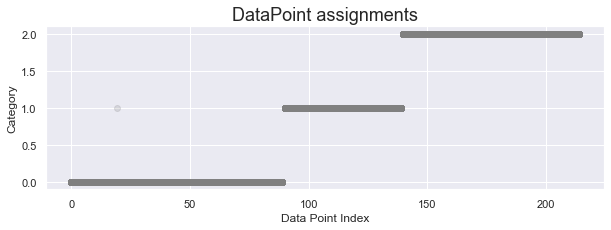

In [105]:
for assign in trace.posterior['category'].values.reshape(-1,215)[-100:]:
    plt.scatter(np.arange(215), assign, color = 'gray', alpha = 0.2)
plt.title('DataPoint assignments', fontsize = 18)
plt.xlabel('Data Point Index')
plt.ylabel('Category')
plt.show()

**Seems like a good fit.**

In [116]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["means", "sigmas", "p",'category','y'], random_seed=42
    )

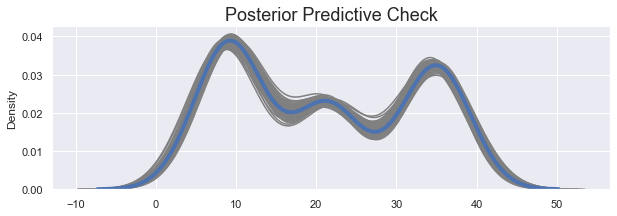

In [136]:
for t in ppc["y"][-100:,:]:
    sns.kdeplot(t, color = 'gray', alpha = 0.01)
sns.kdeplot(mix, lw = 4)
plt.title('Posterior Predictive Check', fontsize = 18)
plt.show()

### Alternative way of using mixture models - Put weights on many of the distributions

In [139]:
with pm.Model() as model:
    
    # probability
    p = pm.Dirichlet('p', np.ones(clusters))
    
    # normal distribution parameters
    means = pm.Normal('means',[10,20,35], sigma = 5, shape = clusters)
    sigmas = pm.Normal('sigmas',5, shape = clusters)
    
    # observed define datapoints, each distributions is drawn with proabability p, passed from w parameter
    y = pm.NormalMixture('y',w = p, mu = means, sigma = sigmas,observed = mix)
    step = pm.Metropolis()
    trace = pm.sample(2000,step)

C:\Users\wanghuan\anaconda3\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigmas]
>Metropolis: [means]
>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000243164B1220>,
      dtype=object)

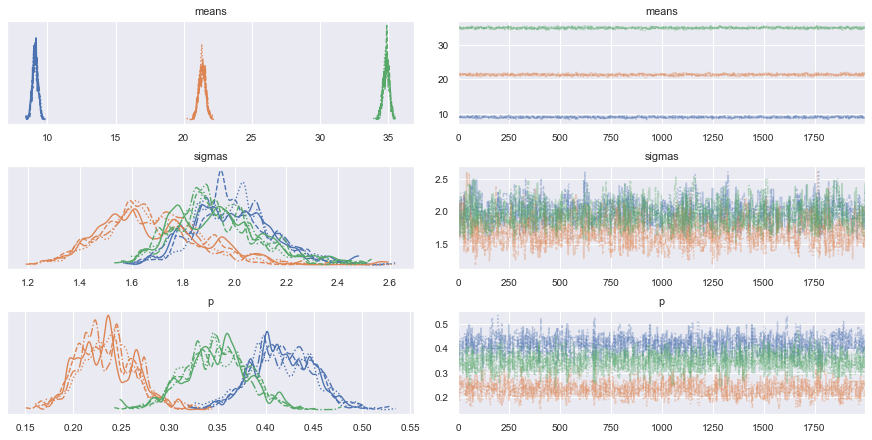

In [140]:
az.plot_trace(trace)

In [141]:
az.summary(trace)

C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],9.106,0.207,8.730,9.490,0.007,0.005,825.0,1034.0,1.00
means[1],21.369,0.248,20.876,21.807,0.011,0.008,523.0,875.0,1.01
means[2],34.879,0.225,34.454,35.298,0.008,0.006,774.0,795.0,1.00
sigmas[0],1.991,0.156,1.710,2.295,0.006,0.004,756.0,1008.0,1.01
sigmas[1],1.679,0.191,1.328,2.015,0.008,0.006,602.0,681.0,1.01
sigmas[2],1.932,0.167,1.618,2.227,0.007,0.005,666.0,780.0,1.01
p[0],0.417,0.033,0.359,0.477,0.001,0.001,790.0,804.0,1.01
p[1],0.235,0.029,0.179,0.287,0.001,0.001,715.0,878.0,1.00
p[2],0.348,0.033,0.295,0.415,0.001,0.001,990.0,1071.0,1.00


In [1]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
df = sns.load_dataset('iris')

In [10]:
x = df.iloc[:,:4].values
y = pd.Categorical(df.species).codes

In [36]:
mus_ = x.mean(axis = 0)
sigmas_ = x.std(axis = 0)
idx = np.arange(len(x))
n_clusters = len(np.unique(y))
n_points, n_features = x.shape


In [93]:
with pm.Model() as model:
    mus = pm.Exponential('mus',1 / mus_, shape = (n_clusters, n_features))
    sigmas = pm.HalfNormal('sigmas', 1, shape = (n_clusters, n_features))
    p = pm.Dirichlet('p',[1,1,1])
    assign = pm.Categorical('assign',p, shape = n_points)
    step = pm.Metropolis()
    obs = pm.Normal('obs', mus[assign], sigmas[assign],  observed = x)
    trace = pm.sample(30000, return_inferencedata = True,step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [assign]
>Metropolis: [p]
>Metropolis: [sigmas]
>Metropolis: [mus]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 64 seconds.
C:\Users\wanghuan\anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


In [94]:
p.random()

array([0.10320235, 0.69466248, 0.20213517])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E59DE3C40>,
      dtype=object)

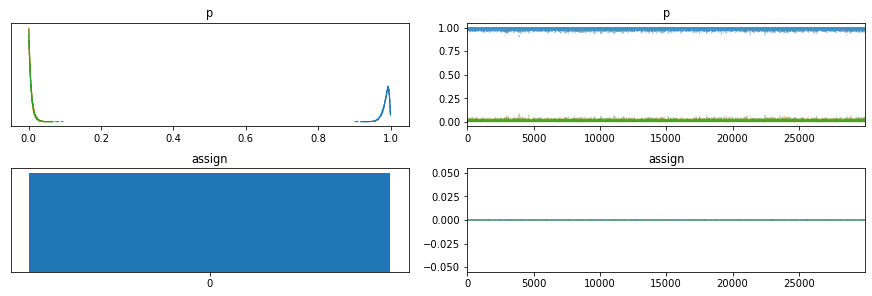

In [95]:
az.plot_trace(trace, var_names = ['p','assign'])